In [ ]:
! git clone https://github.com/nikzagarwal/covid-detection-x-ray.git

fatal: destination path 'covid-detection-x-ray' already exists and is not an empty directory.


In [ ]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
import tensorflow as tf
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D, BatchNormalization
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
#Model Analysis
from sklearn.metrics import confusion_matrix

In [ ]:
path = '/content/covid-detection-x-ray/COVID-19_Radiography_Dataset/'

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [ ]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


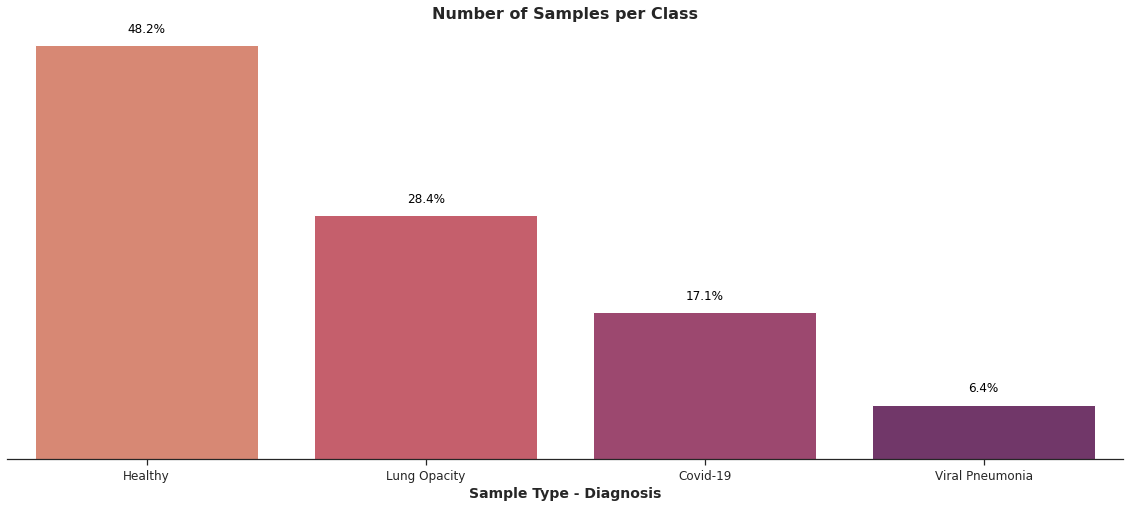

In [ ]:
#Samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [ ]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

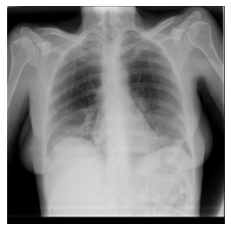

In [ ]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
# print(pic_id)
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off')
plt.show()


# image processing

In [ ]:
from skimage.filters import unsharp_mask
from skimage import exposure

In [ ]:
# Function to load image
def load_image(study_id):
    pic_id = random.randrange(0, samples)
    picture = covidData['path'][pic_id]
    image = cv2.imread(picture)
    pixels = image
    min_pixel = np.min(pixels)
    max_pixel = np.max(pixels)

    # if image.PhotometricInterpretation == "MONOCHROME1":
    #     pixels = max_pixel - pixels
    # else:
    #     pixels = pixels
    return pixels

In [ ]:
# Apply unsharp mask and hist equalization
def unsharp_image(pixels):

    # Tweak the radius and amount for more/less sharpening
    unsharp_image = unsharp_mask(pixels, radius=5, amount=2)
    equalized_image = exposure.equalize_hist(unsharp_image)
    
    return equalized_image

In [ ]:
# Display images
def plot_images(pixels, image_unsharp):
    # Plot both images
    fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True, figsize=(12, 12))
    ax = axes.ravel()
    ax[0].imshow(pixels, cmap=plt.cm.gray)
    ax[0].set_title('Original image')
    ax[1].imshow(image_unsharp, cmap=plt.cm.gray)
    ax[1].set_title('After unsharp / hist eq')
    for a in ax:
        a.axis('off')
    fig.tight_layout()
    plt.show()

7134


/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


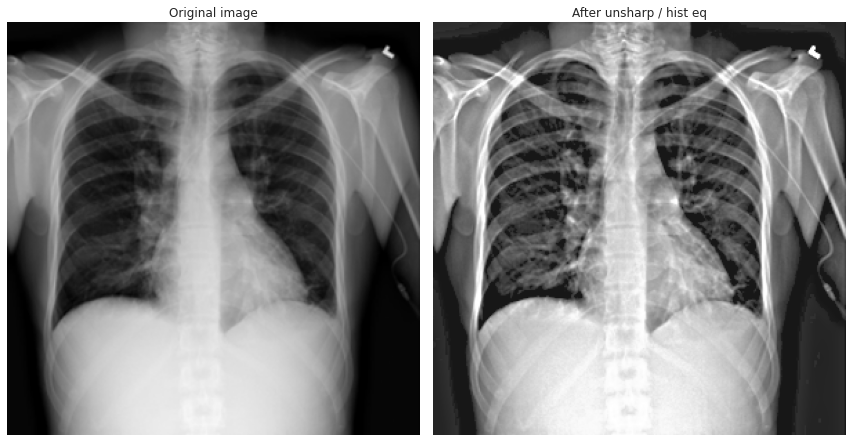

In [ ]:
pic_id = random.randrange(0, samples)
print(pic_id)
# Grab an random study ID and get the pixels
pixels = load_image(pic_id)

# Apply unsharp and hist equalization
pixels_unsharp = unsharp_image(pixels)

# Plot the images
plot_images(pixels, pixels_unsharp)

In [ ]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(unsharp_image(Image.open(x).resize((75,75)))))

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


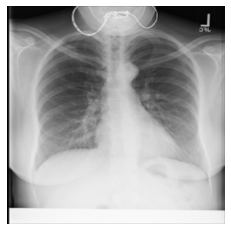

In [ ]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
# print(pic_id)
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
covidData

,image_id,path,diag,target,Class,image
0,Normal-4263,/content/covid-detection-x-ray/COVID-19_Radiog...,Normal,2,Healthy,"[[[0.9874137650943647, 0.9874137650943647, 0.9..."
1,Normal-2393,/content/covid-detection-x-ray/COVID-19_Radiog...,Normal,2,Healthy,"[[[0.5027555555555555, 0.5027555555555555, 0.5..."
2,Normal-5718,/content/covid-detection-x-ray/COVID-19_Radiog...,Normal,2,Healthy,"[[[0.8783222509654752, 0.8783222509654752, 0.8..."
3,Normal-1997,/content/covid-detection-x-ray/COVID-19_Radiog...,Normal,2,Healthy,"[[[0.49422222222222223, 0.49422222222222223, 0..."
4,Normal-6643,/content/covid-detection-x-ray/COVID-19_Radiog...,Normal,2,Healthy,"[[[0.5018666666666667, 0.5018666666666667, 0.5..."
...,...,...,...,...,...,...
21160,Lung_Opacity-294,/content/covid-detection-x-ray/COVID-19_Radiog...,Lung_Opacity,1,Lung Opacity,"[[0.08426666666666667, 0.08426666666666667, 0...."
21161,Lung_Opacity-2272,/content/covid-detection-x-ray/COVID-19_Radiog...,Lung_Opacity,1,Lung Opacity,"[[0.03164444444444445, 0.03164444444444445, 0...."
21162,Lung_Opacity-3612,/content/covid-detection-x-ray/COVID-19_Radiog...,Lung_Opacity,1,Lung Opacity,"[[0.14133333333333334, 0.14133333333333334, 0...."
21163,Lung_Opacity-4340,/content/covid-detection-x-ray/COVID-19_Radiog...,Lung_Opacity,1,Lung Opacity,"[[0.12711111111111112, 0.12711111111111112, 0...."


In [ ]:
print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


In [ ]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

In [ ]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Class');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Class');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Class');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold');

## Model Creation

In [ ]:
#add the path general where the classes subpath are allocated
path = '/content/covid-detection-x-ray/COVID-19_Radiography_Dataset'

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
#classes=["COVID",  "Normal"]
num_classes = len(classes)
batch_size=32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


#load the images to training
train_generator = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")
#load the images to test
validation_generator = val_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


### Data Augementation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model-1 Resnet-50

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',pooling='avg')

model = Sequential([
  Conv2D(3,(3,3), padding='same', input_shape=(224,224,1)),
  base_model,
  Dense(4, activation='softmax'),
])
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,938
Trainable params: 23,542,818
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights1.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
callbacks = [checkpoint, reduce_lr,early_stopping]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/10
529/529 [==============================] - 424s 707ms/step - loss: 0.5524 - accuracy: 0.7986 - val_loss: 1.2745 - val_accuracy: 0.4839

Epoch 00001: saving model to model_weights1.h5
Epoch 2/10
529/529 [==============================] - 377s 712ms/step - loss: 0.2761 - accuracy: 0.9023 - val_loss: 0.7578 - val_accuracy: 0.6813

Epoch 00002: saving model to model_weights1.h5
Epoch 3/10
529/529 [==============================] - 378s 713ms/step - loss: 0.2392 - accuracy: 0.9154 - val_loss: 0.5112 - val_accuracy: 0.8371

Epoch 00003: saving model to model_weights1.h5
Epoch 4/10
529/529 [==============================] - 376s 710ms/step - loss: 0.2072 - accuracy: 0.9257 - val_loss: 2.3981 - val_accuracy: 0.5817

Epoch 00004: saving model to model_weights1.h5
Epoch 5/10
529/529 [==============================] - 377s 713ms/step - loss: 0.2085 - accuracy: 0.9264 - val_loss: 2.0622 - val_accuracy: 0.4770

Epoch 00005: saving model to model_weights1.h5
Epoch 6/10
529/529 [==========

In [ ]:
y_pred = model.predict(validation_generator)

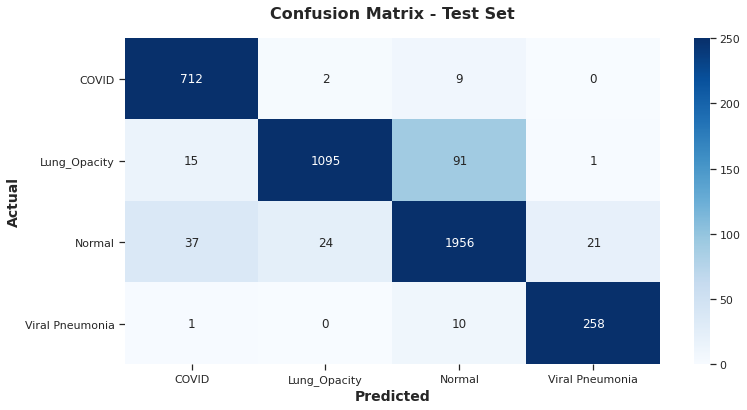

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=validation_generator.classes
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)
len(y_true)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

**Overall Results**
Accuracy Result: 95.01%
Precision Result: 94.39%
Recall Result: 95.37%
F-Score Result: 94.82%


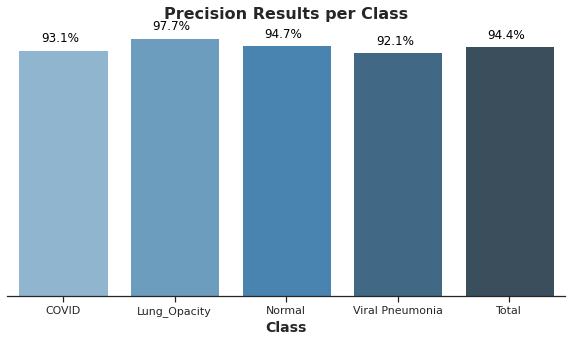

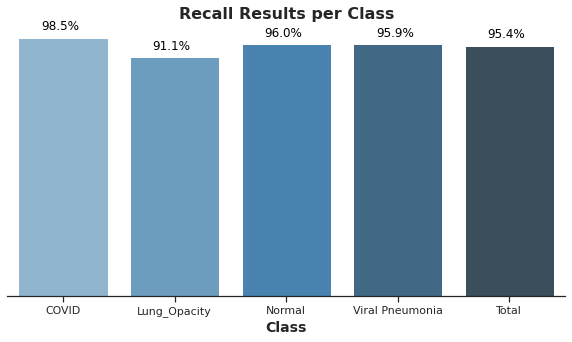

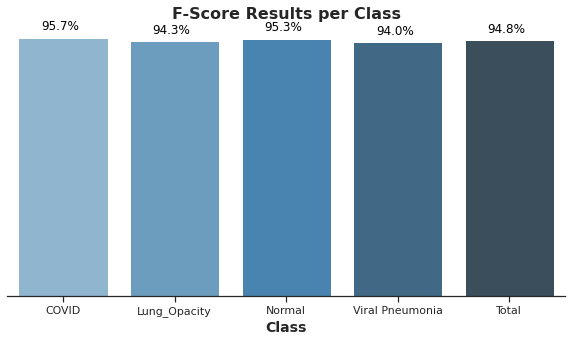

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

acc = accuracy_score(y_true, predictions)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100))
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))